## StackOverflow — сервис вопросов и ответов о программировании

Необходимые данные находятся в таблицах схемы `stackoverflow`. Подключимся к базе с помощью SQLAlchemy.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`.

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

In [6]:
# напишите запрос
query = '''
WITH month_views AS (
                     SELECT DATE_TRUNC('month', creation_date)::date AS month_date,
                            views_count
                     FROM stackoverflow.posts
                     WHERE DATE_PART('year',creation_date) = '2008'
                     )
SELECT DISTINCT month_date,
       SUM(views_count) OVER(PARTITION BY month_date) AS total_views
FROM month_views
ORDER BY total_views DESC;
'''
# выполните запрос
sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

In [7]:
# напишите ваш ответ здесь

#Stack Overflow работает с августа 2008 года, логично, что наименьшее количество просмотров в месяц открытия платформы,
#затем просмотры стабильно растут.

# Задание 2 

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

In [8]:
# напишите запрос
query = '''
WITH hundred_answer AS (
                     SELECT su.display_name,
                            COUNT (sp.id) OVER (PARTITION BY su.display_name),
                            su.id
                     FROM stackoverflow.users AS su INNER JOIN stackoverflow.posts AS sp ON su.id = sp.user_id
                          INNER JOIN stackoverflow.post_types AS spt ON sp.post_type_id = spt.id
                     WHERE DATE_TRUNC('day', su.creation_date) >= (DATE_TRUNC('day', sp.creation_date) - INTERVAL '1 months')  
                           AND spt.type = 'Answer'
                           )
SELECT display_name,
       COUNT (DISTINCT id)
FROM hundred_answer
WHERE count > 100
GROUP BY 1
ORDER BY display_name;
'''
# выполните запрос
sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
74,lomaxx,1
75,mattlant,1
76,paxdiablo,1
77,tvanfosson,1


Какие аномалии наблюдаются в данных? О чём они говорят?

In [9]:
# напишите ваш ответ здесь

# Встречаются некорректно заполненные строки с именем пользователя, например:
# цифры, знаки, слитное написание имени и фамилии, никнейм вместо имени и т.п.

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

In [10]:
# напишите запрос
query = '''
SELECT DISTINCT month,
       COUNT (count_posts.user_id)
FROM (
      SELECT DATE_TRUNC('month', sp.creation_date)::date AS month,
             sp.user_id
      FROM stackoverflow.users AS su INNER JOIN stackoverflow.posts AS sp ON su.id = sp.user_id
      WHERE sp.user_id IN (
                   (SELECT user_id AS id
                   FROM stackoverflow.posts
                   WHERE creation_date::DATE BETWEEN '2008-12-01' AND '2008-12-31')
                   ) AND su.creation_date::DATE BETWEEN '2008-09-01' AND '2008-09-30'
      ) count_posts
GROUP BY 1
ORDER BY month DESC
'''

# выполните запрос
sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

In [11]:
# напишите ваш ответ здесь

# Аномальные значения - 32 поста в августе от пользователей, зарегистрированных в сентябре.
# Возможно, это аккаунты тестировщиков, затем отошедших обычным пользователям.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [12]:
# напишите запрос
query = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM (views_count) OVER (PARTITION BY user_id ORDER BY creation_date) AS cumulative_count
FROM stackoverflow.posts
ORDER BY user_id, creation_date
'''

# выполните запрос
# выполните запрос
sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

In [13]:
# напишите запрос
query = '''
SELECT user_id,
       AVG(count_users.daily)
FROM (
      SELECT user_id,
             DATE_TRUNC('day', creation_date) AS DATE,
             COUNT(id) AS daily
      FROM stackoverflow.posts
      WHERE user_id IN (
                        SELECT user_id
                        FROM stackoverflow.posts
                        WHERE creation_date::DATE BETWEEN '2008-08-01' AND '2008-08-31'
                        GROUP BY user_id
                        HAVING COUNT(id) > 120
                       )
             AND creation_date::DATE BETWEEN '2008-08-01' AND '2008-08-31'
      GROUP BY user_id, DATE_TRUNC('day', creation_date)
      ORDER BY 2) count_users
GROUP BY user_id
ORDER BY 2 ASC
'''

# выполните запрос
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,user_id,avg
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат.

In [14]:
# напишите запрос
query = '''
WITH count_days AS (
                    SELECT COUNT (creation_date) AS count_day
                    FROM (
                          SELECT DISTINCT DATE_TRUNC('day', creation_date) AS creation_date,
                                 user_id
                          FROM stackoverflow.posts
                          WHERE creation_date::DATE BETWEEN '2008-12-01' AND '2008-12-07'
                                AND creation_date IS NOT NULL
                          ) one_post
                    GROUP BY user_id
                    )
SELECT ROUND(AVG(count_day)) AS result
FROM count_days;
'''

# выполните запрос
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,result
0,2.0


Проанализируйте итоговую таблицу — какие выводы можно сделать?

In [15]:
# напишите ваш ответ здесь

# В среднем, в период с 1 по 7 декабря 2008, пользователи публикавали посты 2 дня.

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [16]:
# напишите запрос
query = '''
SELECT DISTINCT user_id,
       creation_date,
       LAG(TO_CHAR(to_timestamp(DATE_PART('month', creation_date)::text, 'MM'),'Month'), 2, NULL) OVER (PARTITION BY user_id ORDER BY creation_date) AS second_last_month
FROM stackoverflow.posts
ORDER BY user_id, creation_date
'''

# выполните запрос
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [17]:
# напишите запрос
query = '''
WITH profile AS (SELECT user_id,
                        DATE_TRUNC('MONTH', creation_date) AS creation_date,
                        COUNT(*) OVER (PARTITION BY DATE_TRUNC('MONTH', creation_date)) AS cohort_users_cnt
                 FROM (
                       SELECT user_id,
                              creation_date,
                              ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY creation_date) AS number_one_day
                       FROM stackoverflow.posts
                       WHERE creation_date IS NOT NULL
                       ) month_one_post
                  WHERE month_one_post.number_one_day = 1),
     sessions AS (SELECT DISTINCT user_id,
                        DATE_TRUNC('MONTH', creation_date) AS session_date
                 FROM stackoverflow.posts
                 WHERE creation_date IS NOT NULL)
SELECT p.creation_date AS cohort_dt,
       session_date,
       COUNT(session_date) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(session_date) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p RIGHT JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,2,4
ORDER BY 1,2,4
''' 
# выполните запрос
df = pd.read_sql_query(query, con=engine)
df

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

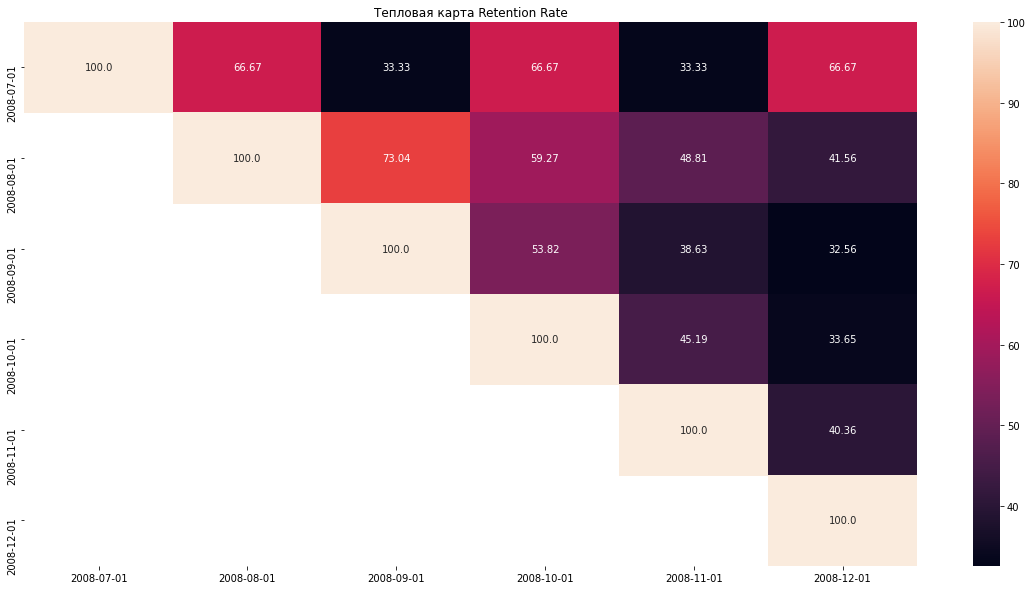

In [18]:
# постройте тепловую карту Retention Rate

retention = df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(20, 10))
sns.heatmap(retention, 
            annot=True, 
            fmt='') 
plt.title('Тепловая карта Retention Rate') 
plt.show()

In [19]:
# опишите аномалии или другие необычные явления и сформулируйте гипотезы

#Июль 2008 года можно не брать в расчёт, вероятнее всего, это был тестовый месяц, всего три пользователя - админы или тестировщики.
# В сентябре возвращается 73% из зарегистрировашихся в августе, что является хорошим показателем, но затем это значение падает ниже
# 50%, что является тревожным знаком.
# Далее значения падают и уже менее 50% пользователей пишут на сайте в новых месяцах. Это может быть поводом направить внимание на
# поиск причин оттока клиентов.

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

In [20]:
# напишите запрос
query = '''
SELECT *,
       ROUND((posts_count * 100/ (CAST (LAG(posts_count) OVER () AS numeric))) - 100 , 2) AS percentage
FROM (
      SELECT DISTINCT CAST (DATE_PART('month', creation_date) AS integer) AS creation_month,
             COUNT(*) OVER (PARTITION BY DATE_TRUNC('MONTH', creation_date)) AS posts_count
      FROM stackoverflow.posts
      WHERE creation_date::DATE BETWEEN '2008-09-01' AND '2008-12-31'
      ) count_posts_month

'''

# выполните запрос
dff = pd.read_sql_query(query, con=engine)
dff

,creation_month,posts_count,percentage
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

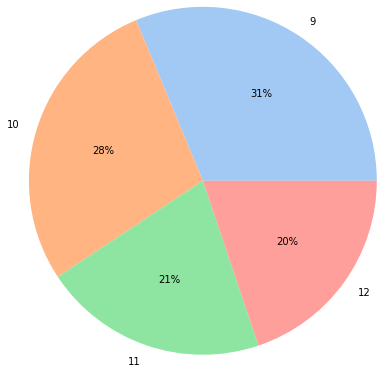

In [21]:
# постройте круговую диаграмму с количеством постов по месяцам

posts_count = dff['posts_count'].tolist()
creation_month = dff['creation_month'].tolist()

data = posts_count
labels = creation_month

colors = sns.color_palette('pastel')[0:5]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%', radius=2)
plt.show()

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

In [22]:
# напишите запрос
query = '''
WITH user_id_top_post AS (                  
                         SELECT user_id AS ud    
                         FROM (
                               SELECT user_id,
                                      (COUNT(creation_date)) AS count_posts
                               FROM stackoverflow.posts
                               GROUP BY user_id
                               ORDER BY count_posts DESC
                              ) AS user_id_top
                        LIMIT 1
                        ),
                        
     number_week_date AS ( 
                          SELECT CAST (DATE_PART('week', creation_date) AS integer) AS week_creation,
                                 creation_date
                          FROM (
                                SELECT user_id,
                                creation_date
                                FROM stackoverflow.posts sp JOIN user_id_top_post ui ON sp.user_id = ui.ud      
                                WHERE user_id = ui.ud AND creation_date::DATE BETWEEN '2008-10-01' AND '2008-10-31'
                               ) AS top_user_date
                         )
                        
SELECT DISTINCT (week_creation),
       MAX(creation_date) OVER (PARTITION BY week_creation) AS creation_date
FROM number_week_date
ORDER BY week_creation

'''

# выполните запрос
sample_df = pd.read_sql_query(query, con=engine)
sample_df

,week_creation,creation_date
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
